# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize
figsize(12, 10)

data = pd.read_csv('/home/akimg/Projects/ML_NeighborsClassifier-master/heart.csv', sep=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [2]:
data.drop('slope', axis='columns')

X = data[data.columns[:-1]]
y = data['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Структура данных

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


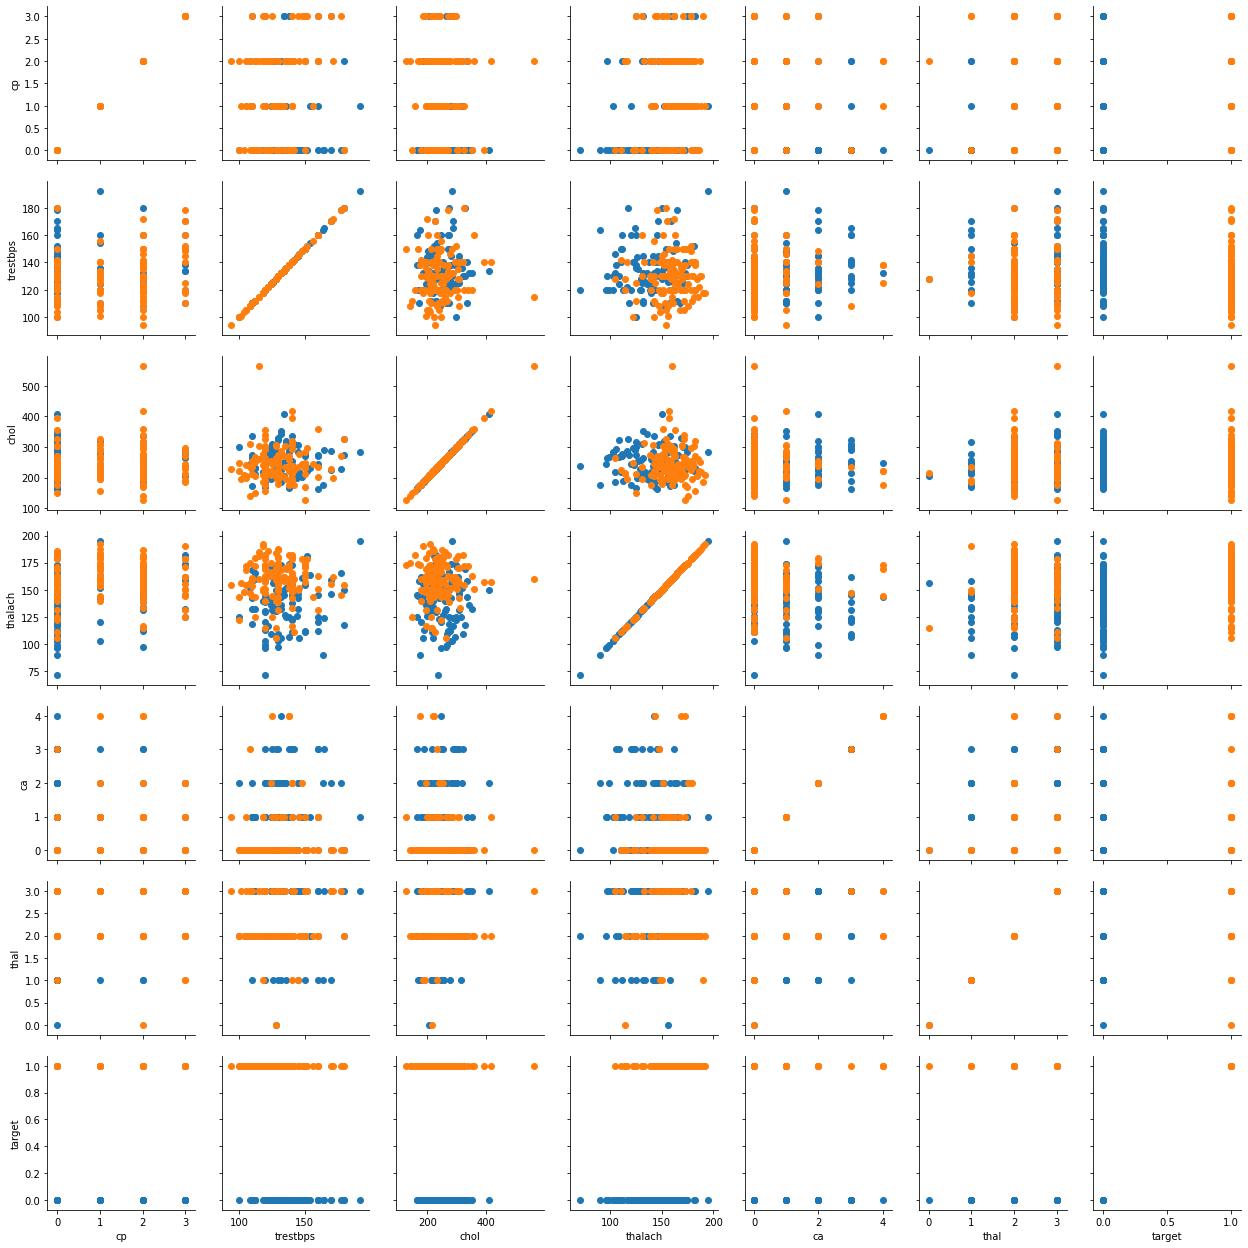

In [3]:
df_for_pairgrid = X_train[['cp', 'trestbps', 'chol', 'thalach', 'ca', 'thal']]
df_for_pairgrid['target'] = y_train

sns.PairGrid(df_for_pairgrid, hue='target').map(plt.scatter)

# Метрики качества

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc

a = np.ones(y_test.shape[0])
accuracy_score(y_test, a)

print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))

Accuracy: 0.5394736842105263
Precision: 0.5394736842105263
Recall: 1.0
ROC AUC: 0.5
PRC AUC: 0.7697368421052632
F1: 0.7008547008547009


# Нормализация признаков

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

print("Качество алгоритма до нормализации:",
      KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train).score(X_test, y_test))

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train, ), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

print("Качество алгоритма после нормализации:",
      KNeighborsClassifier(n_neighbors=10).fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

Качество алгоритма до нормализации: 0.6710526315789473
Качество алгоритма после нормализации: 0.7763157894736842


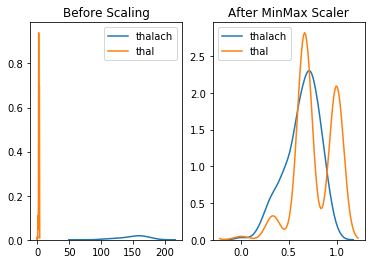

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['thalach'], ax=ax1)
sns.kdeplot(X_train['thal'], ax=ax1)
ax2.set_title('After MinMax Scaler')
sns.kdeplot(X_train_scaled['thalach'], ax=ax2)
sns.kdeplot(X_train_scaled['thal'], ax=ax2)
plt.show()

# Подбор алгоритма

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

X_train_scaled.drop('sex', axis='columns', inplace=True)
X_test_scaled.drop('sex', axis='columns', inplace=True)

for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.7368421052631579
SGDClassifier 0.8157894736842105
SVC 0.7894736842105263
GaussianNB 0.8026315789473685
KNeighborsClassifier 0.8157894736842105


/home/akimg/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Обучим модель

In [8]:
def columns_dropper(X):
    X = X.drop('sex', axis='columns')
    return X

columns_dropper(X_train).columns

Index(['age', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [9]:
from collections import Counter
counter = Counter(X_train['thal'])
cols = ['age', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
        'oldpeak', 'slope', 'ca', 'thal']

def datatype_transform(X):
    for col in cols:
        X[col] = X[col].apply(lambda value: 0.5 if pd.isnull(value) else value)
    X.loc[:, 'thal'] = X['thal'].apply(lambda title: counter.get(title, 0))
    return X

In [10]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer

pipeline = make_pipeline(
    FunctionTransformer(columns_dropper, validate=False),

    FunctionTransformer(datatype_transform, validate=False),
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=5),
)

pipeline

Pipeline(memory=None,
         steps=[('functiontransformer-1',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function columns_dropper at 0x7fff8c2216a8>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('functiontransformer-2',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function datatype_transform at 0x7fff8c221620>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('kneighborsclassifier',
                 KNeighborsClassifi

In [11]:
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.8026315789473685

# Сохраним обученную модель

In [13]:
import pickle

with open("/home/akimg/Projects/ML_NeighborsClassifier-master/lab2/lab2_model.pickle", 'wb') as opened_file:
    pickle.dump(pipeline, opened_file)

In [14]:
import pandas as pd
import pickle

with open("/home/akimg/Projects/ML_NeighborsClassifier-master/lab2/lab2_model.pickle", 'rb') as f:
    model = pickle.load(f)
    
model

Pipeline(memory=None,
         steps=[('functiontransformer-1',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function columns_dropper at 0x7fff8c2216a8>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('functiontransformer-2',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function datatype_transform at 0x7fff8c221620>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('kneighborsclassifier',
                 KNeighborsClassifi

In [15]:
data = pd.read_csv('/home/akimg/Projects/ML_NeighborsClassifier-master/heart.csv', sep=',')
X = data.drop('target', axis='columns')
y = data['target']

model.score(X, y)

0.834983498349835